# Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # boxplot, histplot

import os
import cv2

# Loading Data from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
#!ls "/content/gdrive/My Drive"

df_train = pd.read_csv('/content/gdrive/My Drive/train.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/test.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Exploration
## Missing value and duplicated rows

In [3]:
print(df_train.shape)
df_train.info()
print(df_test.shape)
df_test.info()

(54706, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1)

Observation:

1.   Train set: We have missing values in age, BIRADS and density.
2.   The following features are in df_train rather than df_test: cancer, biopsy, invasive, BIRADS, difficult_negative_case.
3. prediction_id in df_test not in df_train.




In [4]:
df_train.duplicated(df_train,keep=False)
df_train.drop_duplicates(df_train,keep=False)
df_train.info() # No Duplicated Rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

## Patient number and patient age

Patient number: 11913


Text(0.5, 1.0, 'Age distribution of cancer')

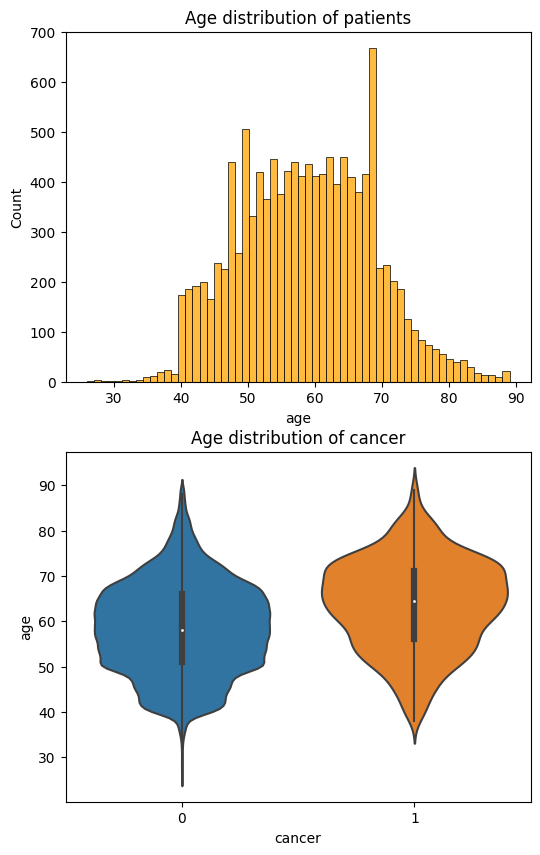

In [5]:
# Souce code: https://www.kaggle.com/code/allunia/rsna-breast-cancer-eda
# Modified by Jia Lin
print('Patient number:', df_train.patient_id.nunique())

ages = df_train[df_train.age.isnull() == False].groupby(
    'patient_id').age.apply(lambda l: np.unique(l)[0])

fig, ax = plt.subplots(2,1,figsize=(6,10))
sns.histplot(ages, color='orange', bins=60, ax=ax[0])
ax[0].set_title('Age distribution of patients')
# Violin plots are used to visualize data distributions, displaying the range, median, and distribution of the data.
sns.violinplot(x=df_train.cancer, y=df_train.age, ax=ax[1])
ax[1].set_title('Age distribution of cancer')

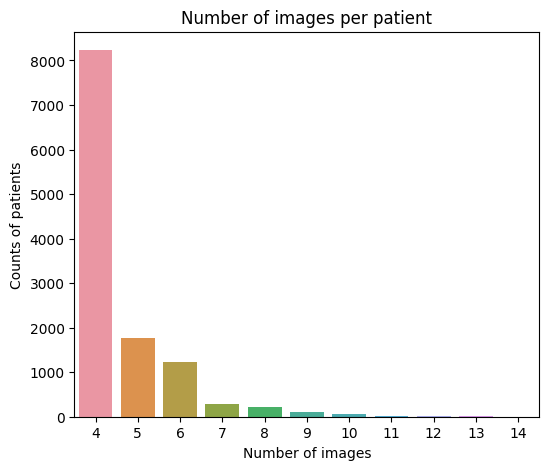

In [6]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
sns.countplot(x=df_train.groupby('patient_id').size(), ax=ax)
ax.set_title('Number of images per patient')
ax.set_xlabel('Number of images')
ax.set_ylabel('Counts of patients');

## Target feature cancer and data balance

In [7]:
df_train['cancer'].unique()
df_train['cancer'].value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

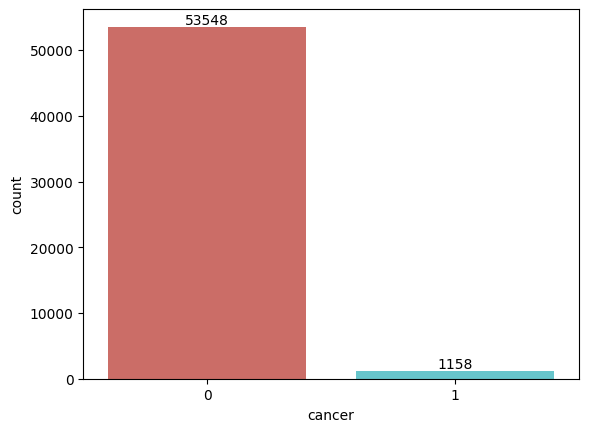

Percentage of benign class is: 97.8832303586444
Percentage of malign class is: 2.11676964135561


In [8]:
# This plot_precentage function is used to calculate and present the proportion of benign and malign classes
def plot_precentage(df):
  ax=sns.countplot(x='cancer', data=df, palette='hls')
  plt.bar_label(ax.containers[0])
  plt.show()
  count_benign = len(df[df['cancer']==0])
  count_malign = len(df[df['cancer']==1])
  pct_of_benign = count_benign/(count_benign+count_malign)
  print("Percentage of benign class is:", pct_of_benign*100)
  pct_of_malign = count_malign/(count_benign+count_malign)
  print("Percentage of malign class is:", pct_of_malign*100)

plot_precentage(df_train)

Observation: The original dataset is extremely imbalance. If build model based on this original dataset, the result will be overfitted as the majority class, i.e. the positive result. We must balance the data before creating the model. In this case, we decided to reduce the number of the majority class, the benign.


In [9]:
# This display function is used to present a list of images
def display(images, row, col):
  fig = plt.figure(figsize=(5, 5))
  for i in range(len(images)):
    fig.add_subplot(row,col,i+1)
    fig.tight_layout(h_pad=0, w_pad=-2)
    plt.imshow(images[i])
    plt.axis('off')

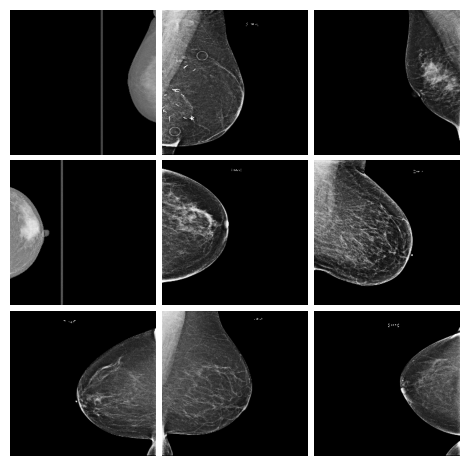

In [10]:
train_path = "/content/gdrive/My Drive/RSNA_256/"
train_images_path = os.listdir(train_path)
train_images = []
for img in train_images_path[:9]:# Only get the first 9 images
  img_path = os.path.join(train_path, img)
  img = cv2.imread(img_path)
  train_images.append(img)
display(train_images, 3, 3)

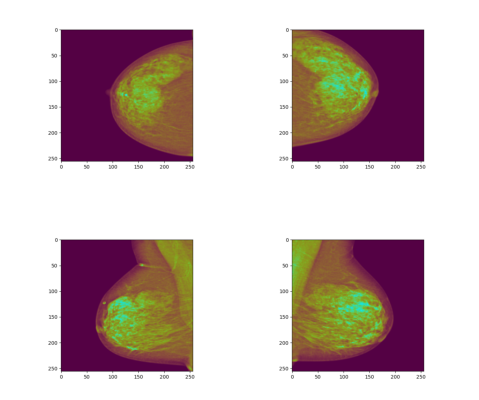

In [11]:
test_path = "/content/gdrive/My Drive/testing_images/"
test_images_path = os.listdir(test_path)
test_images = []
for img in test_images_path:
  img_path = os.path.join(test_path, img)
  img = cv2.imread(img_path)
  test_images.append(img)
display(test_images, 2, 2)